In [55]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdRGroupDecomposition as rdRGD
from IPython.display import SVG
import pandas as pd
import numpy as np
import re

In [103]:

def core_search(mols,core):
    match_mols = []
    for mol in mols:
        if mol.HasSubstructMatch(core):
            match_mols.append(mol)
    return match_mols

def unique_mols(mols):
    has_subs = []
    for mol_i in mols:
        has_subs.append([])
        for mol_j in mols:
            has_subs[-1].append(mol_i.HasSubstructMatch(mol_j))
    unique_mols = []
    for mol,has_sub in zip(mols,has_subs):
        if sum(has_sub) == 1:
            unique_mols.append(mol)
    for mol in mols:
        if sum([mol.HasSubstructMatch(unique_mol) for unique_mol in unique_mols]) == 0:
            unique_mols.append(mol)
    return unique_mols

def unique_mols_by_eq(mols):
    unique_mols = []
    for mol in mols:
        if all([not compare_mol(mol,unique_mol) for unique_mol in unique_mols]):
            unique_mols.append(mol)
    return unique_mols

def print_mols(mols,sub_img_size):
    mols_with_bond_ids = []
    for mol in mols:
        drawer = rdMolDraw2D.MolDraw2DSVG(*sub_img_size)
        drawer.drawOptions().addBondIndices = True
        drawer.drawOptions().atomIndices = True
        drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        mols_with_bond_ids.append(SVG(drawer.GetDrawingText()))
    return mols_with_bond_ids

def merge_svg(svg_list, svg_per_row, offset_x, offset_y):
    # 计算合并后的 SVG 大小
    width = svg_per_row * offset_x
    height = ((len(svg_list) + svg_per_row - 1) // svg_per_row) * offset_y

    # 创建新的 SVG 容器
    merged_svg = f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {width} {height}" width="{width}" height="{height}">\n'
    
    for index, svg in enumerate(svg_list):
        # 提取 SVG 内容
        svg_content = svg.data
        
        # 计算位置
        x_position = (index % svg_per_row) * offset_x
        y_position = (index // svg_per_row) * offset_y
        
        # 添加到合并 SVG 中
        merged_svg += f'<g transform="translate({x_position}, {y_position})">\n'
        merged_svg += svg_content
        merged_svg += '\n</g>\n'

    merged_svg += '</svg>'
    
    return SVG(merged_svg)

def break_bond_and_remove_radicals(mol, bond_idx,mode='id'):
    editable_mol = Chem.RWMol(mol)
    
    bond = editable_mol.GetBondWithIdx(bond_idx)
    begin_atom_idx = bond.GetBeginAtomIdx()
    end_atom_idx = bond.GetEndAtomIdx()
    
    editable_mol.RemoveBond(begin_atom_idx, end_atom_idx)
    
    fragments = Chem.GetMolFrags(editable_mol, asMols=True)
    if mode == 'id':
        fragment = fragments[0]
    else:
        fragment = None
        max_atoms = 0
        for frag in fragments:
            if frag.GetNumAtoms() > max_atoms:
                max_atoms = frag.GetNumAtoms()
                fragment = frag
    
    smiles = Chem.MolToSmiles(fragment)
    if '[CH]' in smiles:
        smiles = smiles.replace('[CH]', 'C')
    elif '[C]' in smiles:
        smiles = smiles.replace('[C]', 'C')
    fragment = Chem.MolFromSmiles(smiles)
    
    return fragment

def break_bond_from_mols(mols, bond_idx, mode='id'):
    new_mols = []
    for i in range(len(mols)):
        if bond_idx[i] < 0:
            new_mols.append(mols[i])
        else:
            new_mols.append(break_bond_and_remove_radicals(mols[i],bond_idx[i],mode))
    return new_mols

def is_all_sub(upper_cores,cores):
    is_sub = []
    for upper_core,core in zip(upper_cores,cores):
        is_sub.append(upper_core.HasSubstructMatch(core))
    return all(is_sub)

def remove_all_double_bonds(mol):
    # 创建一个可编辑的分子对象
    editable_mol = Chem.RWMol()

    # 添加原子到新分子
    atom_mapping = {}
    for atom in mol.GetAtoms():
        new_atom = editable_mol.AddAtom(Chem.Atom(atom.GetAtomicNum()))
        atom_mapping[atom.GetIdx()] = new_atom

    # 添加单键到新分子
    for bond in mol.GetBonds():
        if bond.GetBondTypeAsDouble() == 2.0:  # 判断双键
            # 只添加单键
            editable_mol.AddBond(atom_mapping[bond.GetBeginAtomIdx()], atom_mapping[bond.GetEndAtomIdx()], Chem.BondType.SINGLE)
        else:
            # 原样添加非双键
            editable_mol.AddBond(atom_mapping[bond.GetBeginAtomIdx()], atom_mapping[bond.GetEndAtomIdx()], bond.GetBondType())

    return editable_mol.GetMol()

def compare_mol(mol1, mol2):
    return mol1.HasSubstructMatch(mol2) and mol2.HasSubstructMatch(mol1)

def modify_smarts(smarts):
    
    pattern = re.compile('\[#6H?\d?\]')
    
    smarts = re.sub(pattern, '[#6]', smarts)
    
    return smarts.replace("-","~")

def convert_to_smarts_mol(mols):
    smarts_mols = []
    for mol in mols:
        smarts_mols.append(Chem.MolFromSmarts(modify_smarts(Chem.MolToSmarts(mol))))
    return smarts_mols

def extract_double_bond_positions(mol):
    """提取分子中所有双键的位置。
    
    参数:
    mol : rdkit.Chem.Mol
        需要分析的分子对象。
    
    返回:
    list of tuples
        每个元组包含双键的原子索引。
    """
    double_bond_positions = []
    
    # 遍历所有键
    for bond in mol.GetBonds():
        if bond.GetBondTypeAsDouble() == 2.0:  # 检查是否为双键
            atom1_idx = bond.GetBeginAtomIdx()
            atom2_idx = bond.GetEndAtomIdx()
            double_bond_positions.append((atom1_idx, atom2_idx))
    
    return double_bond_positions

In [3]:
taxane_df = pd.read_excel('/mnt/data/daiql/taxane_datas/taxane_mols_info_v241118.xlsx')

In [4]:
taxane_smiles = taxane_df['Isomeric SMILES'][1:].tolist()

In [5]:
taxane_mols = [Chem.MolFromSmiles(smi) for smi in taxane_smiles]

In [6]:
cores_raw = []
cores_inchikeys = set()
for i,mol in enumerate(taxane_mols):
    core = MurckoScaffold.GetScaffoldForMol(mol)
    Chem.RemoveStereochemistry(core)
    core = Chem.RemoveAllHs(core)
    core_inchikey = Chem.MolToInchiKey(core)
    if core_inchikey not in cores_inchikeys:
        cores_inchikeys.add(core_inchikey)
        cores_raw.append(core)
cores = []
for core in cores_raw:
    if sum(core.HasSubstructMatch(x) for x in cores) == 0:
    # if sum(compare_mol(core,x) for x in cores) == 0:
        cores.append(core)
len(cores)

54

In [7]:
split_bond_ids_v2 = [
    -1,-1,14,
    -1,-1,-1,
    -1,17,-1,
    4,18,-1,
    -1,-1,-1,
    -1,-1,16,
    -1,15,-1,
    15,-1,13,
    -1,15,-1,
    14,16,18,
    18,-1,-1,
    -1,-1,7,
    -1,7,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,12,22,
    -1,-1,-1,
]

In [8]:
cores_v2 = break_bond_from_mols(cores,split_bond_ids_v2)
is_all_sub(cores,cores_v2)

True

In [9]:
split_bond_ids_v3 = [
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,13,19,
    -1,-1,-1,
]

In [10]:
cores_v3 = break_bond_from_mols(cores_v2,split_bond_ids_v3)
is_all_sub(cores_v2,cores_v3)

True

In [11]:
split_bond_ids_v4 = [
    13,14,0,
    -1,16,-1,
    -1,0,15,
    0,10,8,
    13,-1,15,
    1,14,0,
    7,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    0,0,0,
    0,15,2,
    16,14,12,
    12,12,15,
    15,3,-1,
    -1,-1,15,
    14,14,12,
    11,15,18,
    -1,0,14,
]

In [12]:
cores_v4 = break_bond_from_mols(cores_v3,split_bond_ids_v4,"size")
is_all_sub(cores_v3,cores_v4)

True

In [13]:
split_bond_ids_v5 = [
    -1,-1,-1,
    -1,0,-1,
    -1,-1,0,
    -1,0,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    0,0,0,
    -1,0,0,
    0,-1,-1,
    -1,-1,0,
    -1,-1,-1,
    0,0,0,
    -1,-1,0,
]

In [14]:
cores_v5 = break_bond_from_mols(cores_v4,split_bond_ids_v5,"size")
is_all_sub(cores_v4,cores_v5)

True

In [26]:
split_bond_ids_v6 = [
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    0,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
    -1,-1,-1,
]

In [27]:
cores_v6 = break_bond_from_mols(cores_v5,split_bond_ids_v6,"size")
is_all_sub(cores_v5,cores_v6)

True

In [29]:
unique_cores_v6 = unique_mols_by_eq(cores_v6)
len(unique_cores_v6)

39

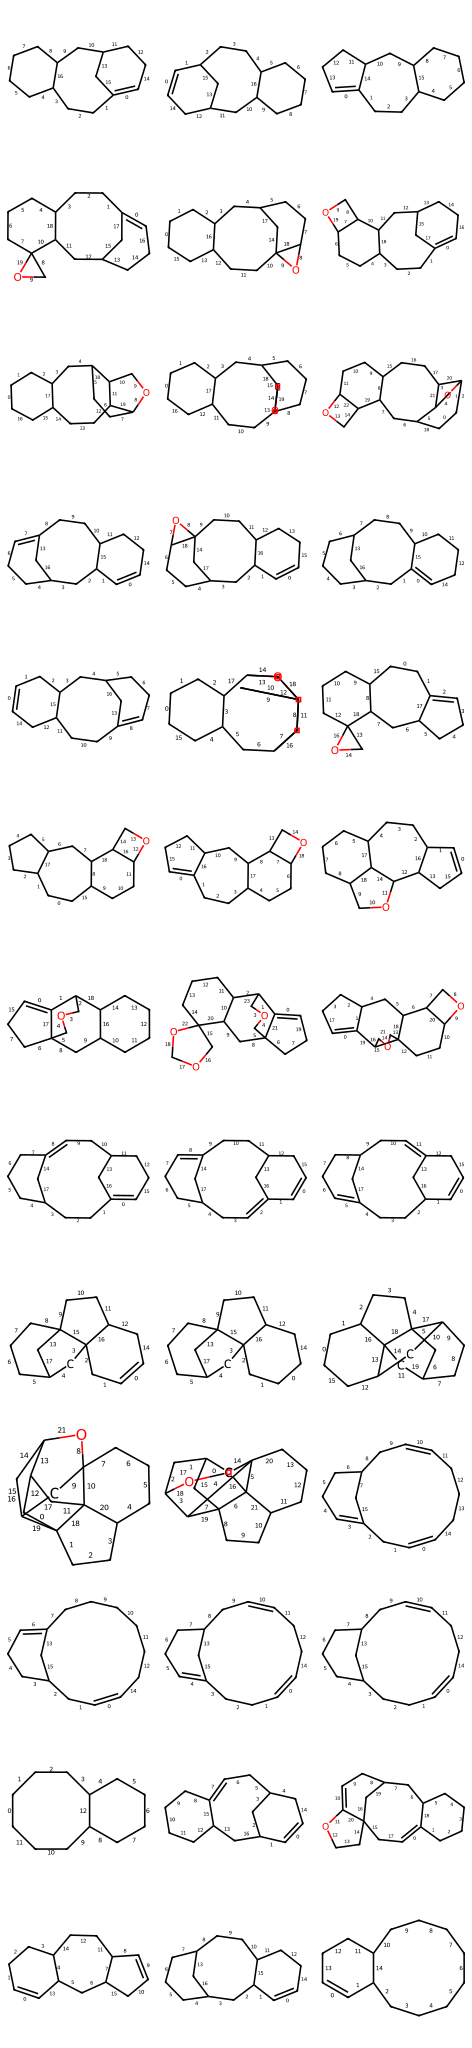

In [30]:
merge_svg(print_mols(unique_cores_v6,(200,200)),3,200,200)

In [31]:
taxane_core_raw_inchi = pd.DataFrame(
    {"inchi":[Chem.MolToInchi(core) for core in unique_cores_v6]}
)

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefined stereo

[18:43:34] WARNING: Omitted undefi

In [32]:
taxane_core_raw_inchi.to_excel("/mnt/data/daiql/taxane_lib/taxane_raw_core.xlsx")

In [34]:
unique_cores_v6_no_double = unique_mols_by_eq([remove_all_double_bonds(mol) for mol in unique_cores_v6])
len(unique_cores_v6_no_double)

24

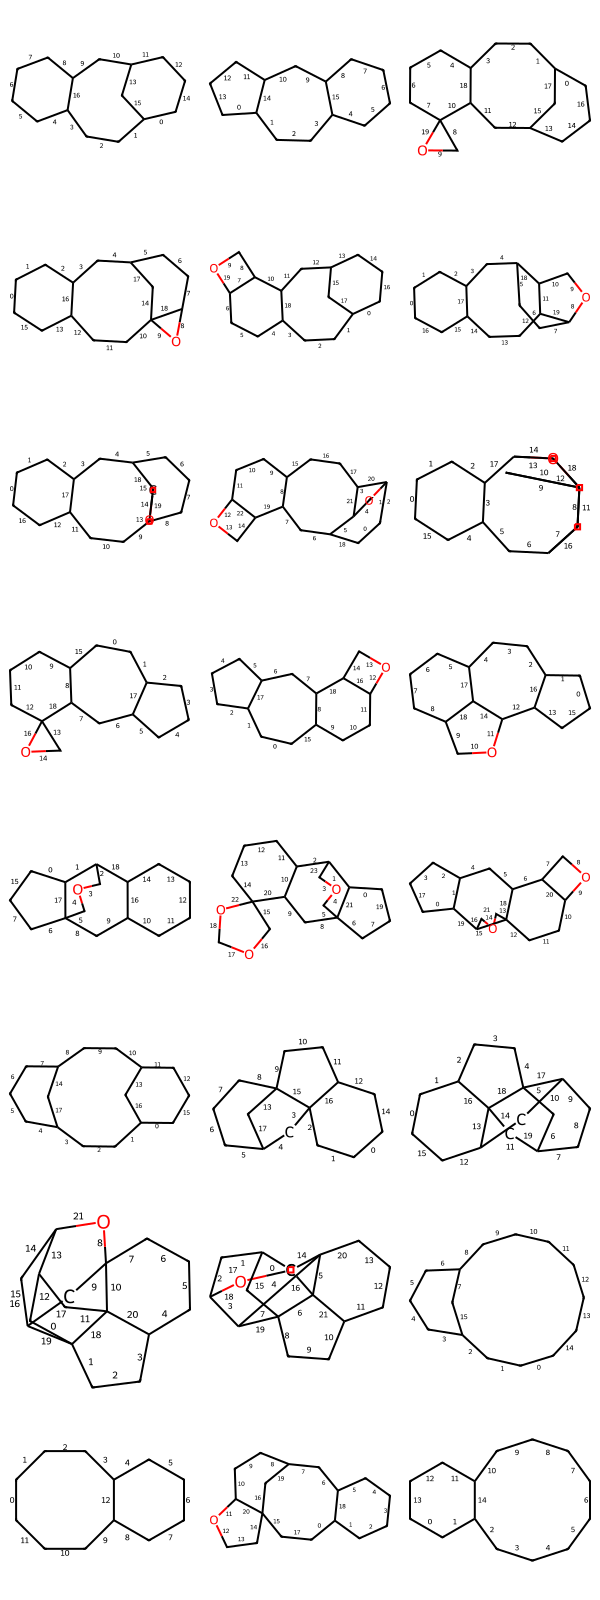

In [35]:
merge_svg(print_mols(unique_cores_v6_no_double,(200,200)),3,200,200)

In [36]:
taxane_core_raw_inchi_no_double = pd.DataFrame(
    {"inchi":[Chem.MolToInchi(core) for core in unique_cores_v6_no_double]}
)

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefined stereo

[19:03:02] WARNING: Omitted undefi

In [37]:
taxane_core_raw_inchi_no_double.to_excel("/mnt/data/daiql/taxane_lib/taxane_raw_core_no_double.xlsx")

In [46]:
unique_cores_v6_smarts = convert_to_smarts_mol(unique_cores_v6_no_double)

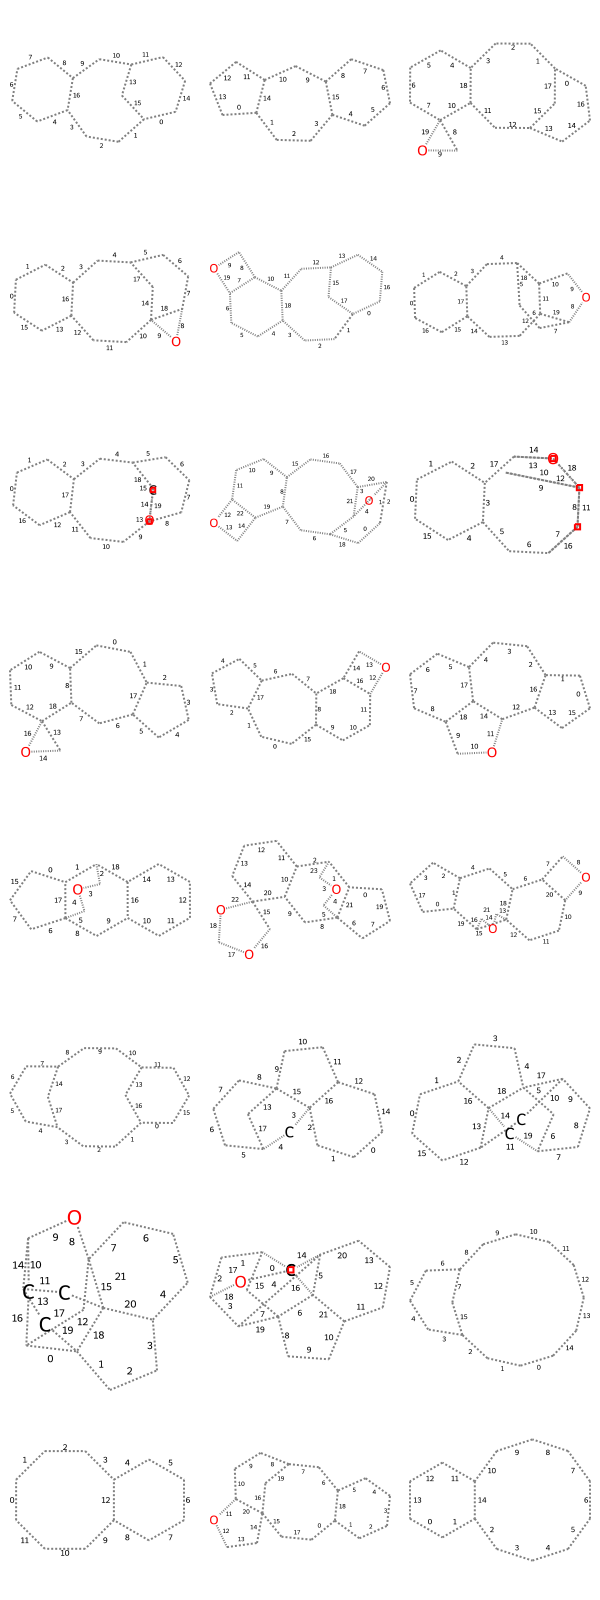

In [47]:
merge_svg(print_mols(unique_cores_v6_smarts,(200,200)),3,200,200)

In [56]:
taxane_core_raw_smarts = pd.DataFrame(
    {"smarts":[Chem.MolToSmarts(core) for core in unique_cores_v6_smarts]}
)

In [58]:
taxane_core_raw_smarts.to_excel("/mnt/data/daiql/taxane_lib/taxane_raw_core_smarts.xlsx")

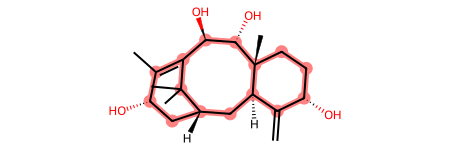

In [86]:
taxane_mols[0]

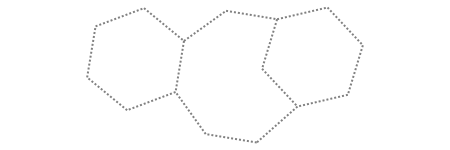

In [51]:
unique_cores_v6_smarts[0]

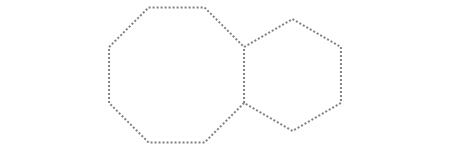

In [81]:
unique_cores_v6_smarts[-3]

In [82]:
match = taxane_mols[0].GetSubstructMatches(unique_cores_v6_smarts[0])
sub = Chem.MolFromSmiles(Chem.MolFragmentToSmiles(taxane_mols[0],atomsToUse=match[0], rootedAtAtom=match[0][0]))

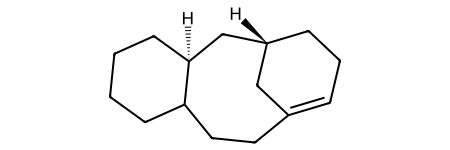

In [87]:
sub

In [88]:
res, unmatched = rdRGD.RGroupDecompose([unique_cores_v6_smarts[0],unique_cores_v6_smarts[-3]], [taxane_mols[0]])

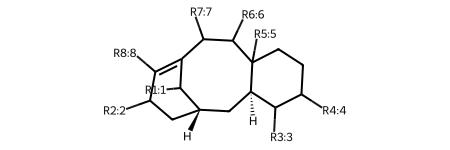

In [114]:
res[0]['Core']

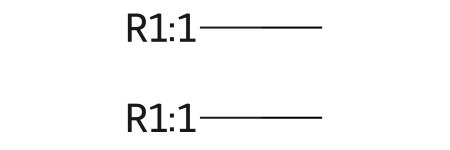

In [102]:
res[0]['R1']

In [111]:
res[0]['R1'].GetPropsAsDict()

{'core': 0,
 'idx': 0,
 'frag_idx': 0,
 'internalRgroupSmiles': '*C([H])([H])[H].*C([H])([H])[H]',
 'RLABEL_PROCESSED': True}

In [104]:
extract_double_bond_positions(res[0]['Core'])

[(4, 5)]